### tf.nn.rnn_cell.BasicRNNCellクラスを用いて、単純なRNNのモデルを作成する。

tf.nn.rnn_cell.BasicRNNCellクラスは、セルの内部構造が単層で全結合のニューラルネットワークを表すクラスである。
インスタンス化の際にニューロンの数をnum_units引数に、活性化関数をactivation引数に指定すればよい。activation引数は省略した場合は、tanh関数という-1～1の範囲をとる関数がデフォルトで設定される。

モデル保存テスト

stock_seriesデータセットのデータフレームへの読み込み

保存コード

C:\Users\mikih\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\mikih\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


step 0, error 0.86447
step 500, error 0.07414
step 1000, error 0.06491
step 1500, error 0.06950
step 2000, error 0.06110
step 2500, error 0.05603
step 3000, error 0.08316
step 3500, error 0.07527
step 4000, error 0.06344
step 4500, error 0.05933
step 5000, error 0.06912
step 5500, error 0.08566
step 6000, error 0.08830
step 6500, error 0.07592
step 7000, error 0.05087
step 7500, error 0.05815
step 8000, error 0.06568
step 8500, error 0.05887
step 9000, error 0.05144
step 9500, error 0.06972
CALC END  step 9999, error 0.05120
Saved a model
INFO:tensorflow:Restoring parameters from ./model/rnn_model
Restored a model


C:\Users\mikih\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


end-start= 0.5605469


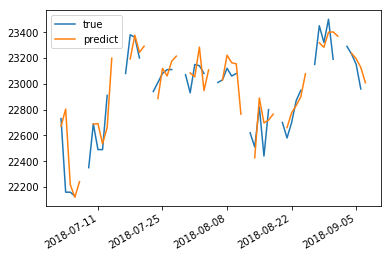

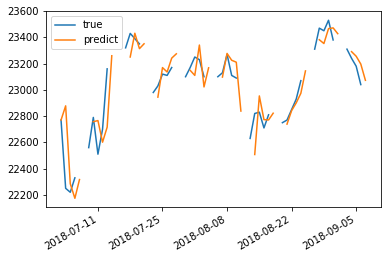

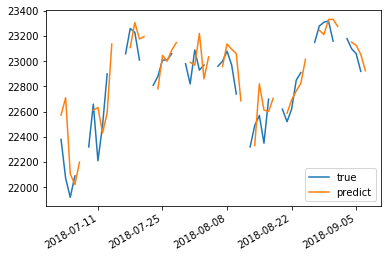

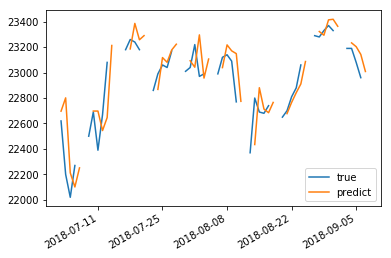

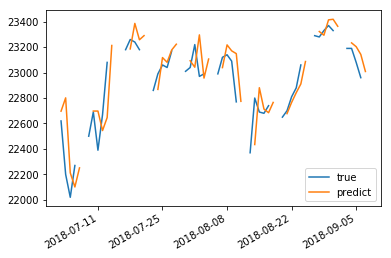

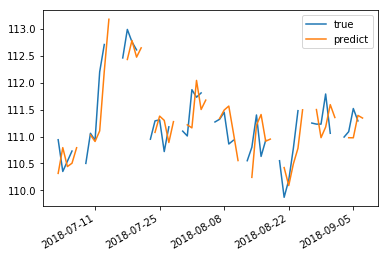

In [1]:
# coding: UTF-8

import pandas as pd
import numpy as np
import tensorflow as tf
import datetime


##### クラス定義
class TimeSeriesDataSet:

  def __init__(self, dataframe):
    self.feature_count = len(dataframe.columns)
    self.series_length = len(dataframe)
    self.series_data = dataframe.astype('float32')

  def __getitem__(self, n):
    return TimeSeriesDataSet(self.series_data[n])

  def __len__(self):
    return len(self.series_data)

  @property
 
  def dates(self):
    return self.series_data.index

  def next_batch(self, length, batch_size):
    """
    連続したlength日のデータおよび１日の誤差測定用データを取得する。
    最後の１日は最終出力データ。
    """
    max_start_index = len(self) - length
    design_matrix = []
    expectation = []
    while len(design_matrix) < batch_size:
      start_index = np.random.choice(max_start_index)
      end_index = start_index + length + 1
      values = self.series_data[start_index:end_index]
      if (values.count() == length + 1).all():  # 切り出したデータ中に欠損値がない
        train_data = values[:-1]
        true_value = values[-1:]
        design_matrix.append(train_data.as_matrix())
        expectation.append(np.reshape(true_value.as_matrix(), [self.feature_count]))
    return np.stack(design_matrix), np.stack(expectation)

  def append(self, data_point):
    dataframe = pd.DataFrame(data_point, columns=self.series_data.columns)
    self.series_data = self.series_data.append(dataframe)

  def tail(self, n):
    return TimeSeriesDataSet(self.series_data.tail(n))

  def as_array(self):
    return np.stack([self.series_data.as_matrix()])

  def mean(self):
    return self.series_data.mean()

  def std(self):
    return self.series_data.std()

  def standardize(self, mean=None, std=None):
    if mean is None:
      mean = self.mean()
    if std is None:
      std = self.std()
    return TimeSeriesDataSet((self.series_data - mean) / std)

##### モデル保存
def save_model(sess):
   saver = tf.train.Saver()
   saver.save(sess, './model/rnn_model')
   print('Saved a model')    

##### モデル復元
def read_model(sess):
   saver = tf.train.Saver()
   saver.restore(sess, './model/rnn_model')
   print('Restored a model')

##### モデル学習
def train_model(sess):
   sess.run(tf.global_variables_initializer())
   for i in range(NUM_TRAIN):
      batch = standardized_train_dataset.next_batch(SERIES_LENGTH, BATCH_SIZE)
      mae, _ = sess.run([loss, optimizer], feed_dict={x: batch[0], y: batch[1]})
      if i % OUTPUT_BY == 0:
          print('step {:d}, error {:.5f}'.format(i, mae))
  
      if i == NUM_TRAIN-1:
          print('CALC END  step {:d}, error {:.5f}'.format(i, mae))

##### 学習結果から予測結果を求める
def rnn_predict(input_dataset):
  # 標準化
  previous = TimeSeriesDataSet(input_dataset).tail(SERIES_LENGTH).standardize(mean=train_mean, std=train_std)
  
  # 予測対象の日付　　predict_time
  from dateutil.relativedelta import relativedelta
  predict_time = previous.dates[-1] +  datetime.timedelta(days=1)  
  
  #print('predict_time:',predict_time)  
    
  # 予測
  batch_x = previous.as_array()
  predict_data = prediction.eval({x: batch_x})

  # 結果のデータフレームを作成
  df_standardized  = pd.DataFrame(predict_data, columns=input_dataset.columns, index=[predict_time])
  # 標準化の逆操作
  return train_mean + train_std * df_standardized

##### 予測日の終値ー始値の値と符号を求める
def  hantei_model(stock_series,dataset):
   predict_stock_series = pd.DataFrame([], columns=stock_series.columns)
   for current_time in test_dataset.dates:
     # < から　<= と　等号をつけることによって、1日先を予測
     predict_result = rnn_predict(stock_series[stock_series.index <= current_time])
     predict_stock_series = predict_stock_series.append(predict_result)


   #print(predict_stock_series)
   #print(predict_stock_series[:]['end'] - predict_stock_series[:]['start'])
   #print('PRED : end‐start=', predict_stock_series[-1:]['end'] - predict_stock_series[-1:]['start'])

   predict_stock_series.to_csv('to_csv_out_20180905fx-0702-USD-NOVOL-matome1man.csv', columns= ['start', 'high', 'low', 'end','adjust','USD'])

   upordown = predict_stock_series.end[-1] - predict_stock_series.start[-1]
  
   #if upordown >= 0:
   #    print('UP')
   #if upordown < 0:
   #    print('DOWN')
        
   #グラフ出力用コード
   #結果だけ必要な場合はplot_data.plotまでコメントアウトする
   # 正解データと予測データ
   correct_2018_year = dataset[dataset.dates > '2018-07-02'].series_data
   predict_2018_year = predict_stock_series
   %matplotlib inline
   for feature in stock_series.columns:
       plot_data = pd.DataFrame({
          'true': correct_2018_year[feature],
          'predict': predict_2018_year[feature]
       }).plot()
       #print(len(stock_series.columns),feature)
   plot_data.plot()         

   return upordown

##### セッション
sess = tf.InteractiveSession()

##### 入力データの設定
stock_series = pd.read_csv('NK225_20180906fx.csv')
###stock_series = pd.read_csv('NK225_20180914fx2013.csv')
stock_series['日付'] = pd.to_datetime(stock_series['日付'])
stock_series.set_index('日付', inplace=True)

##### 不要列の除去
#target_columns =  ['start', 'high', 'low', 'end','volume','adjust','USD', 'GBP','EUR','CAD','AUD','NZD','SGD']
target_columns =  ['start', 'high', 'low', 'end', 'adjust','USD']

stock_series = stock_series[target_columns]


dataset = TimeSeriesDataSet(stock_series)

train_dataset = dataset[ (dataset.dates < '2018-07-02') & (dataset.dates > '2015-01-01') ]
test_dataset = dataset[dataset.dates >= '2018-07-02']

##### 乱数シードの初期化（数値は何でもよい）
np.random.seed(12345)

##### 再現性の確保のために乱数シードを固定
tf.set_random_seed(12345)

##### パラメータ
# 学習日数長さ  72 --->30
SERIES_LENGTH = 30
# 特徴量数
FEATURE_COUNT = dataset.feature_count
# バッチサイズ
BATCH_SIZE = 16
# 学習回数
NUM_TRAIN = 10000
# 学習中の出力頻度
OUTPUT_BY = 500


# 入力（placeholderメソッドの引数は、データ型、テンソルのサイズ）
# 訓練データ
x = tf.placeholder(tf.float32, [None, SERIES_LENGTH, FEATURE_COUNT])
# 教師データ
y = tf.placeholder(tf.float32, [None, FEATURE_COUNT])

##### RNNセルの作成
cell = tf.nn.rnn_cell.BasicRNNCell(20)

initial_state = cell.zero_state(tf.shape(x)[0], dtype=tf.float32)
outputs, last_state = tf.nn.dynamic_rnn(cell, x, initial_state=initial_state, dtype=tf.float32)

##### 全結合　重み、バイアス、最終出力の設定
# 重み
w = tf.Variable(tf.zeros([20, FEATURE_COUNT]))
# バイアス
b = tf.Variable([0.1] * FEATURE_COUNT)

# 最終出力（予測）
prediction = tf.matmul(last_state, w) + b

# 損失関数（平均絶対誤差：MAE）と最適化（Adam）
loss = tf.reduce_mean(tf.map_fn(tf.abs, y - prediction))
optimizer = tf.train.AdamOptimizer().minimize(loss)

# 標準化
train_mean = train_dataset.mean()
train_std = train_dataset.std()
standardized_train_dataset = train_dataset.standardize()

# 1回学習した後は、train_model, save_modelはコメントアウト
# 学習の実行
train_model(sess)

save_model(sess)

read_model(sess)

upordown=hantei_model(stock_series,dataset)

print('end-start=', upordown )




復元コード

INFO:tensorflow:Restoring parameters from ./model/rnn_model
Restored a model


C:\Users\mikih\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


end-start= 9.621094


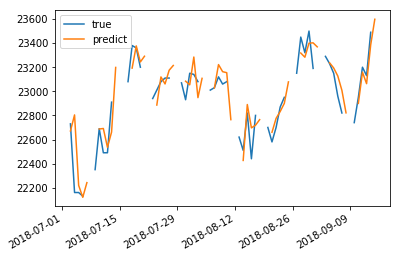

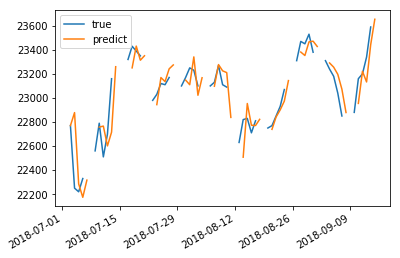

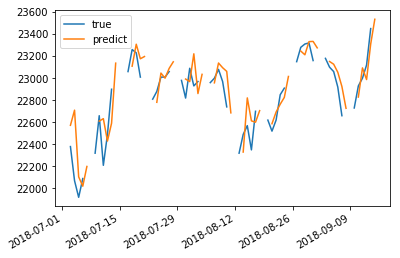

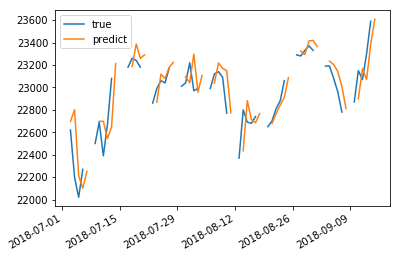

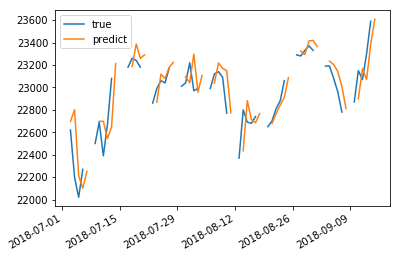

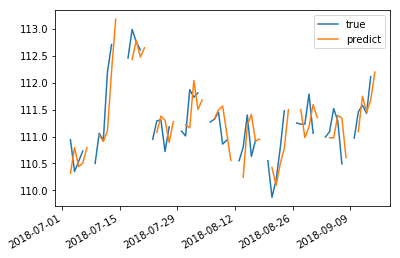

In [1]:
# coding: UTF-8

import pandas as pd
import numpy as np
import tensorflow as tf
import datetime


##### クラス定義
class TimeSeriesDataSet:

  def __init__(self, dataframe):
    self.feature_count = len(dataframe.columns)
    self.series_length = len(dataframe)
    self.series_data = dataframe.astype('float32')

  def __getitem__(self, n):
    return TimeSeriesDataSet(self.series_data[n])

  def __len__(self):
    return len(self.series_data)

  @property
 
  def dates(self):
    return self.series_data.index

  def next_batch(self, length, batch_size):
    """
    連続したlength日のデータおよび１日の誤差測定用データを取得する。
    最後の１日は最終出力データ。
    """
    max_start_index = len(self) - length
    design_matrix = []
    expectation = []
    while len(design_matrix) < batch_size:
      start_index = np.random.choice(max_start_index)
      end_index = start_index + length + 1
      values = self.series_data[start_index:end_index]
      if (values.count() == length + 1).all():  # 切り出したデータ中に欠損値がない
        train_data = values[:-1]
        true_value = values[-1:]
        design_matrix.append(train_data.as_matrix())
        expectation.append(np.reshape(true_value.as_matrix(), [self.feature_count]))
    return np.stack(design_matrix), np.stack(expectation)

  def append(self, data_point):
    dataframe = pd.DataFrame(data_point, columns=self.series_data.columns)
    self.series_data = self.series_data.append(dataframe)

  def tail(self, n):
    return TimeSeriesDataSet(self.series_data.tail(n))

  def as_array(self):
    return np.stack([self.series_data.as_matrix()])

  def mean(self):
    return self.series_data.mean()

  def std(self):
    return self.series_data.std()

  def standardize(self, mean=None, std=None):
    if mean is None:
      mean = self.mean()
    if std is None:
      std = self.std()
    return TimeSeriesDataSet((self.series_data - mean) / std)

##### モデル保存
def save_model(sess):
   saver = tf.train.Saver()
   saver.save(sess, './model/rnn_model')
   print('Saved a model')    

##### モデル復元
def read_model(sess):
   saver = tf.train.Saver()
   saver.restore(sess, './model/rnn_model')
   print('Restored a model')

##### モデル学習
def train_model(sess):
   sess.run(tf.global_variables_initializer())
   for i in range(NUM_TRAIN):
      batch = standardized_train_dataset.next_batch(SERIES_LENGTH, BATCH_SIZE)
      mae, _ = sess.run([loss, optimizer], feed_dict={x: batch[0], y: batch[1]})
      if i % OUTPUT_BY == 0:
          print('step {:d}, error {:.5f}'.format(i, mae))
  
      if i == NUM_TRAIN-1:
          print('CALC END  step {:d}, error {:.5f}'.format(i, mae))

##### 学習結果から予測結果を求める
def rnn_predict(input_dataset):
  # 標準化
  previous = TimeSeriesDataSet(input_dataset).tail(SERIES_LENGTH).standardize(mean=train_mean, std=train_std)
  
  # 予測対象の日付　　predict_time
  from dateutil.relativedelta import relativedelta
  predict_time = previous.dates[-1] +  datetime.timedelta(days=1)  
  
  #print('predict_time:',predict_time)  
    
  # 予測
  batch_x = previous.as_array()
  predict_data = prediction.eval({x: batch_x})

  # 結果のデータフレームを作成
  df_standardized  = pd.DataFrame(predict_data, columns=input_dataset.columns, index=[predict_time])
  # 標準化の逆操作
  return train_mean + train_std * df_standardized

##### 予測日の終値ー始値の値と符号を求める
def  hantei_model(stock_series,dataset):
   predict_stock_series = pd.DataFrame([], columns=stock_series.columns)
   for current_time in test_dataset.dates:
     # < から　<= と　等号をつけることによって、1日先を予測
     predict_result = rnn_predict(stock_series[stock_series.index <= current_time])
     predict_stock_series = predict_stock_series.append(predict_result)


   #print(predict_stock_series)
   #print(predict_stock_series[:]['end'] - predict_stock_series[:]['start'])
   #print('PRED : end‐start=', predict_stock_series[-1:]['end'] - predict_stock_series[-1:]['start'])

   predict_stock_series.to_csv('to_csv_out_20180905fx-0702-USD-NOVOL-matome1man.csv', columns= ['start', 'high', 'low', 'end','adjust','USD'])

   upordown = predict_stock_series.end[-1] - predict_stock_series.start[-1]
  
   #if upordown >= 0:
   #    print('UP')
   #if upordown < 0:
   #    print('DOWN')
        
   #グラフ出力用コード
   #結果だけ必要な場合はplot_data.plotまでコメントアウトする
   # 正解データと予測データ
   correct_2018_year = dataset[dataset.dates > '2018-07-02'].series_data
   predict_2018_year = predict_stock_series
   %matplotlib inline
   for feature in stock_series.columns:
       plot_data = pd.DataFrame({
          'true': correct_2018_year[feature],
          'predict': predict_2018_year[feature]
       }).plot()
       #print(len(stock_series.columns),feature)
   plot_data.plot()         

   return upordown

##### セッション
sess = tf.InteractiveSession()

##### 入力データの設定
###stock_series = pd.read_csv('NK225_20180906fx.csv')
stock_series = pd.read_csv('NK225_20180914fx2013.csv')
stock_series['日付'] = pd.to_datetime(stock_series['日付'])
stock_series.set_index('日付', inplace=True)

##### 不要列の除去
#target_columns =  ['start', 'high', 'low', 'end','volume','adjust','USD', 'GBP','EUR','CAD','AUD','NZD','SGD']
target_columns =  ['start', 'high', 'low', 'end', 'adjust','USD']

stock_series = stock_series[target_columns]


dataset = TimeSeriesDataSet(stock_series)

train_dataset = dataset[ (dataset.dates < '2018-07-02') & (dataset.dates > '2015-01-01') ]
test_dataset = dataset[dataset.dates >= '2018-07-02']

##### 乱数シードの初期化（数値は何でもよい）
np.random.seed(12345)

##### 再現性の確保のために乱数シードを固定
tf.set_random_seed(12345)

##### パラメータ
# 学習日数長さ  72 --->30
SERIES_LENGTH = 30
# 特徴量数
FEATURE_COUNT = dataset.feature_count
# バッチサイズ
BATCH_SIZE = 16
# 学習回数
NUM_TRAIN = 1000
# 学習中の出力頻度
OUTPUT_BY = 500


# 入力（placeholderメソッドの引数は、データ型、テンソルのサイズ）
# 訓練データ
x = tf.placeholder(tf.float32, [None, SERIES_LENGTH, FEATURE_COUNT])
# 教師データ
y = tf.placeholder(tf.float32, [None, FEATURE_COUNT])

##### RNNセルの作成
cell = tf.nn.rnn_cell.BasicRNNCell(20)

initial_state = cell.zero_state(tf.shape(x)[0], dtype=tf.float32)
outputs, last_state = tf.nn.dynamic_rnn(cell, x, initial_state=initial_state, dtype=tf.float32)

##### 全結合　重み、バイアス、最終出力の設定
# 重み
w = tf.Variable(tf.zeros([20, FEATURE_COUNT]))
# バイアス
b = tf.Variable([0.1] * FEATURE_COUNT)

# 最終出力（予測）
prediction = tf.matmul(last_state, w) + b

# 損失関数（平均絶対誤差：MAE）と最適化（Adam）
loss = tf.reduce_mean(tf.map_fn(tf.abs, y - prediction))
optimizer = tf.train.AdamOptimizer().minimize(loss)

# 標準化
train_mean = train_dataset.mean()
train_std = train_dataset.std()
standardized_train_dataset = train_dataset.standardize()

# 1回学習した後は、train_model, save_modelはコメントアウト
# 学習の実行
##### train_model(sess)

##### save_model(sess)

read_model(sess)

upordown=hantei_model(stock_series,dataset)

print('end-start=', upordown )


